In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PART1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


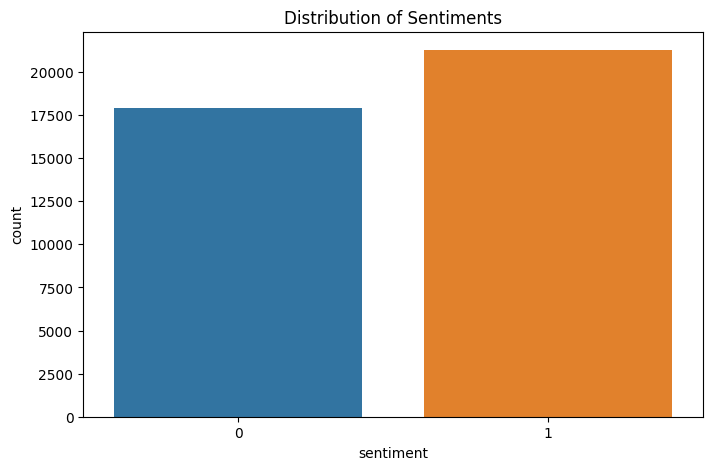

.vector_cache/glove.6B.zip: 862MB [02:43, 5.28MB/s]                           
100%|█████████▉| 399999/400000 [00:48<00:00, 8265.75it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


File not found: /content/drive/MyDrive/sentiment/sentiment_images/COCO_val2014_000000359276.jpg
File not found: /content/drive/MyDrive/sentiment/sentiment_images/COCO_val2014_000000130712.jpg
File not found: /content/drive/MyDrive/sentiment/sentiment_images/COCO_val2014_000000359276.jpg
File not found: /content/drive/MyDrive/sentiment/sentiment_images/COCO_val2014_000000359276.jpg
File not found: /content/drive/MyDrive/sentiment/sentiment_images/COCO_val2014_000000359276.jpg
File not found: /content/drive/MyDrive/sentiment/sentiment_images/COCO_val2014_000000130712.jpg
File not found: /content/drive/MyDrive/sentiment/sentiment_images/COCO_val2014_000000359276.jpg
File not found: /content/drive/MyDrive/sentiment/sentiment_images/COCO_val2014_000000421673.jpg
File not found: /content/drive/MyDrive/sentiment/sentiment_images/COCO_val2014_000000310622.jpg
File not found: /content/drive/MyDrive/sentiment/sentiment_images/COCO_val2014_000000359276.jpg
File not found: /content/drive/MyDrive/s

In [ ]:
from google.colab import drive
import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch
from torchvision import models
import re
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from torchtext.vocab import GloVe
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

drive.mount('/content/drive')

nltk.download('punkt')
data = pd.read_csv("/content/drive/MyDrive/sentiment/sentiment.csv")

plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='sentiment')
plt.title('Distribution of Sentiments')
plt.show()

data.drop(columns=['Unnamed: 0'], inplace=True)

def clean_and_tokenize_caption(caption):
    caption = re.sub(r'[^\w\s]', '', caption).lower()
    words = word_tokenize(caption)
    return words

data['tokens'] = data['raw'].apply(clean_and_tokenize_caption)

glove = GloVe(name='6B', dim=300)

def tokens_to_embeddings(tokens, embedding=glove, embedding_dim=300, max_length=None):
    if max_length is None:
        max_length = max(len(t) for t in tokens)

    embeddings = np.zeros((max_length, embedding_dim))

    for i, token in enumerate(tokens[:max_length]):
        embeddings[i] = embedding[token]

    return embeddings

transform = transforms.Compose([
    transforms.Resize(224),  # Changed to 224 to match with ResNet input
    transforms.CenterCrop(224),  # Changed to 224 to match with ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model
cnn_model = models.resnet50(pretrained=True)
# Remove last layer (we only want to extract features, not classify with this model)
cnn_model = nn.Sequential(*list(cnn_model.children())[:-1])
cnn_model.to(device)
cnn_model.eval()  # Make sure to use eval mode


def preprocess_and_extract_features(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        features = cnn_model(image_tensor)
        return features.squeeze().cpu()
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        return torch.zeros(2048)  # ResNet50 outputs 2048-dimensional features

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])

class MultiModalModel(nn.Module):
    def __init__(self, text_feature_dim, image_feature_dim, num_classes):
        super(MultiModalModel, self).__init__()

        self.text_branch = nn.Sequential(
            nn.Linear(text_feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.image_branch = nn.Sequential(
            nn.Linear(image_feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, text_inputs, image_inputs):
        text_features = self.text_branch(text_inputs)
        text_features = text_features.mean(dim=1)

        image_features = self.image_branch(image_inputs)

        combined_features = torch.cat((text_features, image_features), dim=1)

        output = self.classifier(combined_features)
        return output

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_feature_dim = 300
image_feature_dim = 2048  # Updated to match ResNet output
num_classes = len(data['sentiment'].unique())
model = MultiModalModel(text_feature_dim, image_feature_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

class SentimentDataset(Dataset):
    def __init__(self, dataframe, image_folder, max_length, transform):
        self.data = dataframe
        self.image_folder = image_folder
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        tokens = clean_and_tokenize_caption(row['raw'])
        text_features = tokens_to_embeddings(tokens, max_length=self.max_length)
        text_features = torch.tensor(text_features).float()
        image_path = os.path.join(self.image_folder, row['filename'])
        image_features = preprocess_and_extract_features(image_path)
        sentiment = torch.tensor(row['sentiment'])
        return text_features, image_features, sentiment

image_folder = "/content/drive/MyDrive/sentiment/sentiment_images/"
max_length = data['tokens'].apply(len).max()
batch_size = 16

train_dataset = SentimentDataset(train_data, image_folder, max_length, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SentimentDataset(test_data, image_folder, max_length, transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (text_features, image_features, sentiment) in enumerate(train_dataloader):
        text_features = text_features.to(device)
        image_features = image_features.to(device)
        sentiment = sentiment.to(device)

        optimizer.zero_grad()
        outputs = model(text_features, image_features)
        loss = criterion(outputs, sentiment)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")

print("Training complete.")

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for text_features, image_features, sentiment in test_dataloader:
        text_features = text_features.to(device)
        image_features = image_features.to(device)
        outputs = model(text_features, image_features)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(sentiment.tolist())
        y_pred.extend(predicted.tolist())

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

# Specify the file path for saving the model
model_file = "/content/drive/MyDrive/sentiment/multimodal_model.pth"

# Save the trained model
torch.save(model.state_dict(), model_file)

In [ ]:

# Specify the file path for saving the model
model_file = "/content/drive/MyDrive/sentiment/multimodal_model.pth"

# Save the trained model
torch.save(model.state_dict(), model_file)

PART2

In [ ]:
from google.colab import drive
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from ast import literal_eval
from torch import nn
import torch.nn.functional as F
from torchvision import models, transforms

drive.mount('/content/drive')

# Data preprocessing
data = pd.read_csv("/content/drive/MyDrive/sentiment/sentiment.csv")

# Generate n-grams
vectorizer = CountVectorizer(ngram_range=(1, 5))
X = vectorizer.fit_transform(data['text'])

# Building a vocabulary
vocab = {word: i + 4 for i, word in enumerate(vectorizer.get_feature_names_out())}
vocab["<pad>"] = 0
vocab["<start>"] = 1
vocab["<end>"] = 2
vocab["<unk>"] = 3

# Pad sequences
max_seq_length = X.shape[1]

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
class MyDataset(Dataset):
    def __init__(self, data, path, transform=None):
        self.data = data
        self.transform = transform
        self.path = path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]["filename"]
        img_path = os.path.join(self.path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            return None

        if self.transform:
            img = self.transform(img)

        text = torch.tensor(X[idx].toarray(), dtype=torch.float)

        label = self.data.iloc[idx]["sentiment"]
        label = torch.tensor(label, dtype=torch.float)

        return img, text, label

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_dataset = MyDataset(train_data, "/content/drive/MyDrive/sentiment/sentiment_images", transform=transform)
test_dataset = MyDataset(test_data, "/content/drive/MyDrive/sentiment/sentiment_images", transform=transform)

class MultimodalModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, img_dim, hidden_dim, output_dim):
        super(MultimodalModel, self).__init__()

        self.text_layer = nn.Linear(vocab_size, embed_dim)

        self.img_layer1 = models.resnet50(pretrained=True)
        self.img_layer1.fc = nn.Linear(self.img_layer1.fc.in_features, img_dim)

        self.final_layer1 = nn.Linear(img_dim + embed_dim, hidden_dim)
        self.final_layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, img, text):
        img_out = self.img_layer1(img)
        text_out = self.text_layer(text)
        combined = torch.cat((img_out, text_out), dim=1)

        out = F.relu(self.final_layer1(combined))
        out = self.final_layer2(out)
        return out

# Hyperparameters
num_epochs = 10
learning_rate = 0.01
batch_size = 32
vocab_size = len(vocab)
embed_dim = 100
img_dim = 1000
hidden_dim = 500
output_dim = 1  # change this to match the number of labels in your dataset

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU is available.")
else:
  device = torch.device("cpu")
  print("GPU not available, CPU used.")

model = MultimodalModel(vocab_size, embed_dim, img_dim, hidden_dim, output_dim).to(device)

criterion = nn.MSELoss() # Use Mean Squared Error Loss for regression problem
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
  model.train()
  for i, (images, texts, label) in enumerate(train_loader):
    images = images.to(device)
    texts = texts.to(device)
    label = label.to(device)

    outputs = model(images, texts)

    # Compute the loss
    loss = criterion(outputs, label)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

model.eval() # set the model to evaluation mode
total_loss = 0
total_items = 0

with torch.no_grad():
  for i, (images, texts, label) in enumerate(test_loader):
    images = images.to(device)
    texts = texts.to(device)
    label = label.to(device)
        # Forward pass
    outputs = model(images, texts)

    # Compute the loss
    loss = criterion(outputs, label)

    total_loss += loss.item() * images.size(0)
    total_items += images.size(0)
avg_test_loss = total_loss / total_items
print(f'Average test loss: {avg_test_loss:.4f}')

model.eval() # Set the model to evaluation mode
true_labels = []
pred_labels = []

with torch.no_grad():
  correct = 0
  total = 0
  for i, (images, texts, label) in enumerate(test_loader):
    images = images.to(device)
    texts = texts.to(device)
    label = label.to(device)

    # Forward pass
    outputs = model(images, texts)

    _, predicted = torch.max(outputs.data, 1)

    # Flatten the tensors and calculate the correct predictions
    correct += (predicted.view(-1) == label.view(-1)).sum().item()

    # Calculate the total number of items
    total += label.nelement()

    # Append true and predicted labels to the lists
    true_labels.extend(label.view(-1).cpu().numpy())
    pred_labels.extend(predicted.view(-1).cpu().numpy())

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


GPU is available.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10/10, Loss: 0.02055501751601696
Average test loss: 0.0192
Test Accuracy of the model on the test images: 97.51661979033496 %


In [ ]:

# Specify the file path for saving the model
model_file = "/content/drive/MyDrive/sentiment/mm2.pth"

# Save the trained model
torch.save(model.state_dict(), model_file)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


PART3

In [ ]:

import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

img_url = '11.jpg'
raw_image = Image.open(img_url).convert('RGB')

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))




a photography of a little girl smiling while eating a piece of cake
there is a little girl that is eating a piece of cake


In [ ]:

import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration, pipeline

# Initialize the captioning model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

# Initialize the sentiment analysis model
sentiment_model = pipeline("sentiment-analysis")

img_url = '/content/drive/MyDrive/sentiment/sentiment_images/COCO_val2014_000000389081.jpg'
raw_image = Image.open(img_url).convert('RGB')

# Generate multiple captions
inputs = processor(raw_image, return_tensors="pt")
outputs = model.generate(**inputs, num_return_sequences=10, num_beams=10)

# Process each caption
captions = [processor.decode(out, skip_special_tokens=True) for out in outputs]

# Compute sentiment for each caption
sentiments = [sentiment_model(caption)[0] for caption in captions]

# Filter for positive captions
positive_captions = [caption for caption, sentiment in zip(captions, sentiments) if sentiment['label'] == 'POSITIVE']

# If there are no positive captions, just return the first caption
if not positive_captions:
    print(captions[0])
else:
    # Choose the most positive caption
    max_positive_sentiment = max([sentiment['score'] for sentiment in sentiments if sentiment['label'] == 'POSITIVE'])
    most_positive_caption = [caption for caption, sentiment in zip(positive_captions, sentiments) if sentiment['score'] == max_positive_sentiment]

    print(most_positive_caption[0])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


there is a plate of french fries and a sandwich on a table
